# Estimating the state of the economy with finite mixture models and the EM algorithm

**Finite mixture models assume the existence of a latent, unobserved variable that impacts the distribution from which the data are generated.** This idea has numerous practical applications: for instance, stock prices might change according to some assumed model, but the parameters of this model are likely to be different during bull and bear markets. In this case, the latent variable is the state of the economy, a somewhat undefined term, but a very impactful one.

Fitting finite mixtures to data comprises estimating the parameters of the distributions from which the data might come, as well as the probability of coming from each of them. **This allows us to quantify and estimate important but undefined and unobservable variables, such as the already mentioned state of the economy!** It is no easy task, though, with the standard maximum likelihood approach. Luckily, the clever expectation-maximization (or EM) algorithm comes to rescue.

This article is split into three parts, discussing the following topics:
1. What the EM algorithm is, how it works, and how to implement it in Python.
2. How to apply it in practice to estimate the state of the economy.
3. Appendix: the math behind the EM algorithm for curious readers.

Let's dive straight in!

# The Expectation-Maximization algorithm

We will discuss the EM algorithm using some randomly generated data first. Let's start with the data generating process. Let's say our data might come from two different normal distributions. One is described by a mean of -4 and the standard deviation of 2. For the other, the parameters are 11 and 3, respectively.

$data_1 \sim N(\mu_{1}, \sigma_{1})$, &nbsp;&nbsp;&nbsp; with $\mu_{1} = -4$ and $\sigma_{1} = 2$

$data_2 \sim N(\mu_{2}, \sigma_{2})$, &nbsp;&nbsp;&nbsp; with $\mu_{2} = 11$ and $\sigma_{2} = 3$

The data we actually obseve are a mixture of the above two, defined as

$data = \Delta * data_1 + (1 - \Delta) * data_2$,

where $\Delta \in \{0, 1\}$ with the probability $p$ of being $1$. In our example, let's set $p$ to 0.65. Consequently, if for a given data point, if $\Delta = 1$, it comes from the distribution $data_{1}$, and if $\Delta = 0$, it comes from $data_{2}$. Here, $\Delta$ is the latent variable we would not observe in reality which impacts the data generation process. Let's generate some data according to this process and plot their histogram.

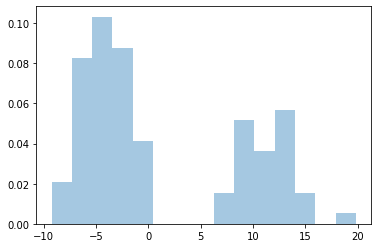

In [793]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

data_1 = np.random.normal(-4, 2, 100),
data_2 = np.random.normal(11, 3, 100)
deltas = np.random.binomial(1, 0.65, 100)
data = np.squeeze(deltas * data_1 + (1 - deltas) * data_2)

sns.distplot(data, bins=15, kde=False, norm_hist=True)
plt.show()

A quick look at the plot suggests the data might have arisen under a mixture of two normals. Hence, a finite mixutre of two Gaussians seems to be the appropriate model for these data. Remember: all we observe is the data, and what we need to estimate are the parameters: $\mu_{1}$, $\sigma_{1}$, $\mu_{2}$, $\sigma_{2}$, and $p$, called the mixing probability, which is the probability of the data coming from one of the distributions - say the first one.

The likelihood of such data is very hard to maximize analitically. If you'd like to know why, scroll down to the mathematical appendix. But there is another way - the EM algorithm. It's a method providing the (possibly local) maximum of the log-likelihood function using an iterative two-step procedure:
* Expectation (E) step,
* Maximization (M) step.

In the E-step, we compute the so-called *complete data likelihood function*, based on the joint density of the data and the latent variable $\Delta$. In the M-step, we maximize the expectation of this function. We repeat the two steps iteratively, untile the parameter estimates do not change anymore. All the mathematical derivations are relegated to the appendix below; for now, let me just offer you out-of-the-box formulas.

In the case of our mixture of two Gaussians, the E-step comprises computing the probability that $p = 1$ given the other parameters, denoted as $pp1$:

$pp1 = \frac{p * \phi(data; \mu_{1}, \sigma{1})}{p * \phi(data; \mu_{1}, \sigma_{1}) + (1 - p) * \phi(data; \mu_{2}, \sigma_{2})}$,

where $\phi(data; \mu_{1}, \sigma_{1})$ is the probability density of the data under the first distribution, a Gaussian with mean $\mu_{1}$ and standard deviation $\sigma_{1}$. Let's code it down:

In [ ]:
# E-step: compute the conditional (posterior) probability that p = 1 (pp1), 
# given the other parameters
data_pdf_1 = norm.pdf(data, loc=mu_1, scale=sigma_1)
data_pdf_2 = norm.pdf(data, loc=mu_2, scale=sigma_2)
pp1 = (p * data_pdf_1) / (p * data_pdf_1 + (1 - p) * data_pdf_2)

The maximizing formulas applied in the M-step are as follows (scroll to the bottom for the derivations):

$p = \frac{1}{N}\Sigma pp1$

$\mu_{1} = \frac{\Sigma (pp1 * data)}{\Sigma pp1}$

$\sigma_{1} = \sqrt{\frac{\Sigma (pp1 * (data - \mu_{1})^{2})}{\Sigma pp1}}$

The formulas for $\mu_{2}$ and $\sigma_{2}$ are the same, except that they use $(1 - pp1)$ in place of $pp1$. Let's translate it into Python:

In [ ]:
# M-step: maximize the pp1 with respect to the parameters
p = np.mean(pp1)
mu_1 = np.sum(pp1 * data) / np.sum(pp1)
mu_2 = np.sum((1 - pp1) * data) / np.sum((1 - pp1))
sigma_1 = np.sqrt(np.sum(pp1 * (data - mu_1)**2) / np.sum(pp1))
sigma_2 = np.sqrt(np.sum((1 - pp1) * (data - mu_2)**2) / np.sum((1 - pp1)))

As you see, the E-step conditions on the parameters $\mu_{1}$, $\sigma_{1}$, $\mu_{2}$, $\sigma_{2}$, and $p$, and the M-step updates them. To get it started, we need to initialize these parameters before we run the first E-step iteration. A popular choce is to set the means $\mu$ to any random data points drawn from the data, the standard deviations $\sigma$ to the standard deviation of the data, and $p$ to 0.5:

In [ ]:
# Initial guesses for the parameters
mu_1 = np.random.choice(data)
mu_2 = np.random.choice(data)
sigma_1 = np.std(data)
sigma_2 = np.std(data)
p = 0.5

We have now coded the entire EM algorithm! Let's put all this code together into a class called `TwoGaussiansMixture()` with a `fit()` method which takes `data` and `num_iter` as arguments, initializes the parameters and iterates through the E and M steps for `num_iter` iterations. The class will also have three other utility methods:
* `predict()`, which takes some data `x` and produces the predicted PDF of our fitted Gaussian mixture for these data,
* `get_mixing_probability()`, which takes some data `x` and returns the probability of coming from one of the distributions for each data point,
* `plot_predictions_on_data()`, which plots the PDF produced by `predict()` on top of the histogram of the original data.

In [802]:
class TwoGaussiansMixture():
    
    def fit(self, data, num_iter):
        
        # Initial guesses for the parameters
        self.mu_1 = np.random.choice(data)
        self.mu_2 = np.random.choice(data)
        self.sigma_1 = np.std(data)
        self.sigma_2 = np.std(data)
        self.p = 0.5
        self.data = data

        for i in range(num_iter):
        
            # E-step: compute the conditional (posterior) probability that p = 1 (pp1), 
            # given the other parameters
            data_pdf_1 = norm.pdf(data, loc=self.mu_1, scale=self.sigma_1)
            data_pdf_2 = norm.pdf(data, loc=self.mu_2, scale=self.sigma_2)
            pp1 = (self.p * data_pdf_1) / (self.p * data_pdf_1 + (1 - self.p) * data_pdf_2)
            
            # M-step: maximize the pp1 with respect to the parameters
            self.p = np.mean(pp1)
            self.mu_1 = np.sum(pp1 * data) / np.sum(pp1)
            self.mu_2 = np.sum((1 - pp1) * data) / np.sum((1 - pp1))
            self.sigma_1 = np.sqrt(np.sum(pp1 * (data - self.mu_1)**2) / np.sum(pp1))
            self.sigma_2 = np.sqrt(np.sum((1 - pp1) * (data - self.mu_2)**2) / np.sum((1 - pp1)))
    
    def predict(self, x):
        return (self.p * norm.pdf(x, self.mu_1, self.sigma_1) +
                (1 - self.p) * norm.pdf(x, self.mu_2, self.sigma_2))
    
    def get_mixing_probability(self, x):
        return self.p * norm.pdf(x, self.mu_1, self.sigma_1) / self.predict(x)
    
    def plot_prediction_on_data(self, show_mixing_prob=False):
        x = np.linspace(self.data.min(), self.data.max(), self.data.shape[0])
        fitted = self.predict(x)
        sns.distplot(self.data, bins=15, kde=False, norm_hist=True)
        sns.lineplot(x, fitted)
        if show_mixing_prob:
            mixing_prob = self.get_mixing_probability(x)
            sns.lineplot(x, mixing_prob)
        plt.show()

Now, let's fit our model to the data with 100 iterations and plot the predicted PDF.

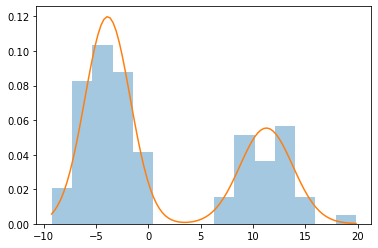

In [804]:
model = TwoGaussiansMixture()
model.fit(data, num_iter=100)
model.plot_prediction_on_data()

The blue histogram is exactly the same as the one above, depicting the original data. The orange line is the probability density, or PDF, of the Gaussian mixture we have fit. It fits data pretty well! We can also plot the mixing probability on top of the plot above.

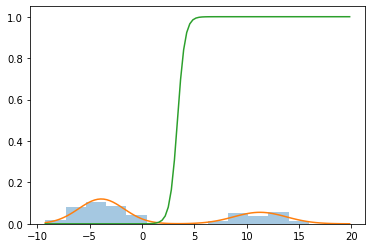

In [805]:
model.plot_prediction_on_data(show_mixing_prob=True)

On the left-hand side of the plot the mixing probability is close to zero, meaning that the model is sure the values on the x-axis come from the left distribution. The more we go to the right, the more sure the model becomes that the data come from the other one.

Finally, let's look at the parameters. Where they estimated correctly?

In [807]:
print(model.mu_1, model.mu_2, model.sigma_1, model.sigma_2, p)

11.263067573735341 -3.893589091692746 2.5184757384087786 2.162510874493102 0.2999296508820708


Recall the true means were -4 and 11, the standard deviations were 2 and 3, and $p$ was 0.65 (so $1 - p$ was 0.35 - the model does not care which distribution is which). The parameter estimates seem close to the true values!

# Estimating the state of the economy

Now that we have seen have seen how the EM algorithm works on some randomly generated data, let's put this knowledge to practice! The plot below shows the quarterly GDP growth rate in the US since 1967 until 2019. The red stripes are time periods declared as recessions by the Federal Reserve. We can see that recessions are associated with the GDP growth rate going down sharply.

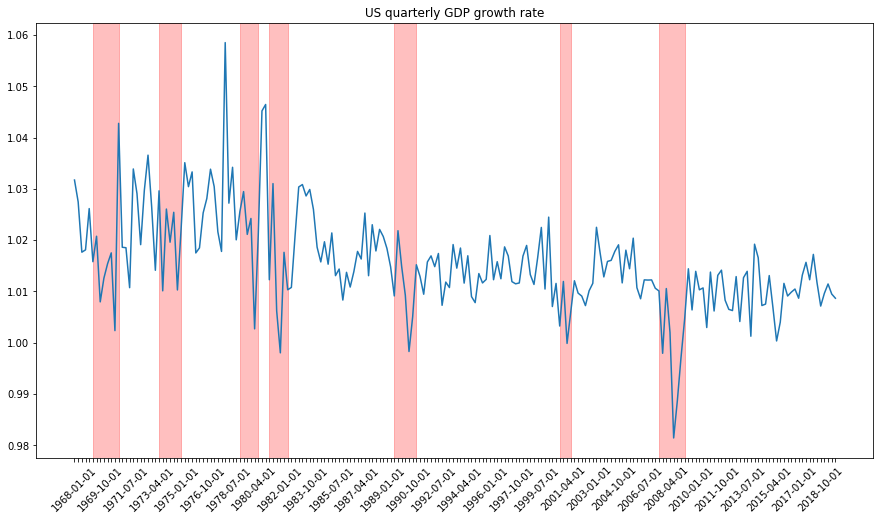

In [812]:
gdp = pd.read_csv("us_gdp.csv")
recession = pd.read_csv("us_recessions.csv").rename(columns={"JHDUSRGDPBR": "recession"})
data = gdp.merge(recession, on="DATE", how = "inner")

data["gdp_growth_rate"] = data["GDP"] / data["GDP"].shift(1)
data = data.iloc[1:, ]
recession["recession_shift"] = data["recession"] - data["recession"].shift(1)
recession = recession.loc[(recession["recession_shift"] != 0) & (~recession["recession_shift"].isna())]
recession_starts = recession["DATE"].iloc[::2, ].reset_index(drop=True)
recession_ends = recession["DATE"].iloc[1::2, ].reset_index(drop=True)

plt.figure(figsize=(15, 8))
plt.plot(data["DATE"], data["gdp_growth_rate"])
plt.xticks(rotation=45)
for rec_id in range(len(recession_starts)):
    plt.axvspan(recession_starts[rec_id], recession_ends[rec_id], alpha=0.25, color='red')
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::7]))
for label in temp:
    label.set_visible(False)
plt.title("US quarterly GDP growth rate")
plt.show()

Let's compare the histogrms of the GDP growth rate for recession vs non-recession time.

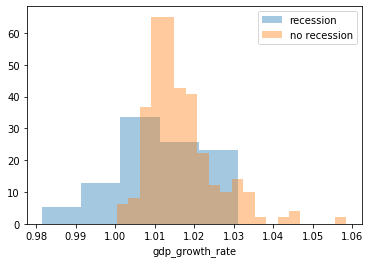

In [813]:
recession = data.loc[data["recession"] == 1]
no_recession = data.loc[data["recession"] == 0]
sns.distplot(recession["gdp_growth_rate"], kde=False, label="recession", norm_hist=True)
sns.distplot(no_recession["gdp_growth_rate"], kde=False, label="no recession", norm_hist=True)
plt.legend()
plt.show()

Looks like two Gaussians? That's a great use-case for our `TwoGaussiansMixture()` model! In this context, we assume that the GPD growth rate has a normal distribution with parameters depending on the latent variable $\Delta$, which is either 1 or 0: recession or no recession. The parameter $p$ in this setting can be read as the probability of a recession, a great estimate of the state of the economy.

We will re-use our `TwoGaussiansMixture()` class, along the `get_mixing_probability()` method to compute $p$ for each original data point. Since the raw probabilities $p$ are quite noisy, we will smooth them with a rolling average.

In [825]:
recession_model = TwoGaussiansMixture()
recession_model.fit(data["gdp_growth_rate"], num_iter=100)
recession_prob = recession_model.get_mixing_probability(data["gdp_growth_rate"])
recession_prob = pd.Series(recession_prob).rolling(6).mean()

Now, let's plot out estimated probability of recession versus the Fed-declared recessions.

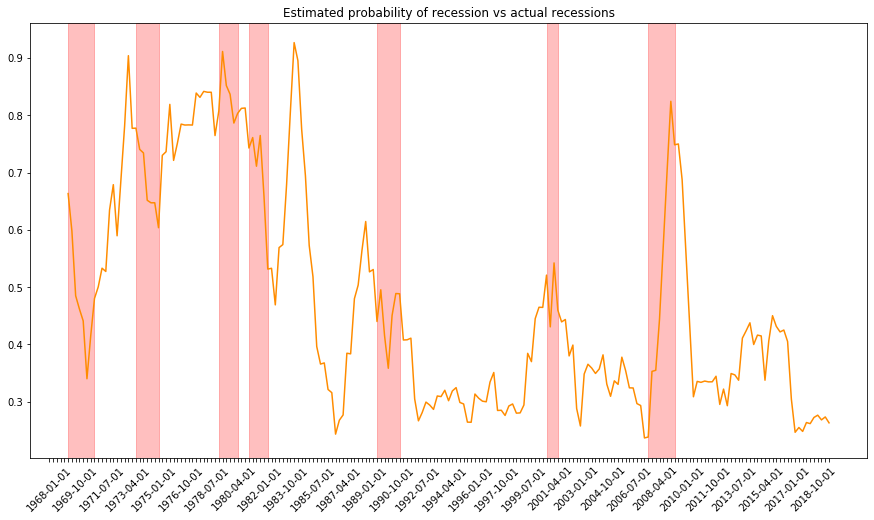

In [827]:
plt.figure(figsize=(15, 8))
plt.plot(data["DATE"], recession_prob, c="darkorange")
plt.xticks(rotation=45)
for rec_id in range(len(recession_starts)):
    plt.axvspan(recession_starts[rec_id], recession_ends[rec_id], alpha=0.25, color='red')
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::7]))
for label in temp:
    label.set_visible(False)
plt.title("Estimated probability of recession vs actual recessions")
plt.show()

In the last three recessions: the housing bubble of 2007, the dot-com bubble of the early 2000s, and the oil price shock of 1990, our estimates peak, indicating high probabilities of recessions, which indeed took place. Some of the earlier ones have been captured pretty well too, although 1983, for which the model indicates a 90% probability of a recession, actually did not see one.

Perhaps the model is not perfect, but remember that the only data it gets to see are the GPD growth rates, and it outputs a probabilistic estimate of the state of the economy - may be the predicted peak in 1983 captures a danger the economy almost crashed into?

Thanks for reading! If you are curious about where do the EM equations come from, feel free to dive into the math appendix below. Otherwise, grab some data and build a finite mixture model yourself! All the code, including the one producing the plots is available [here](). You can also check out my other articles [here]().

# Appendix: The mathematics of the EM algorithm

In this optional section, we will show why we had to use the EM algorithm to estimate the mixture model. We will also derive the formulas we have applied earlier.

Recall the data generating process is the following:

$data_1 \sim N(\mu_{1}, \sigma_{1})$,

$data_2 \sim N(\mu_{2}, \sigma_{2})$,

$data = \Delta * data_1 + (1 - \Delta) * data_2$,

where $\Delta \in \{0, 1\}$ with the probability $p$ of being $1$.

Let's denote all the model parameters jointly as $\theta = \{\mu_{1}, \sigma_{1}, \mu_{2}, \sigma_{2}, p$\}.

Since *data* is a mixture of two Gaussians and the data points are independent, the likelihood function of the data is the product across the Gaussian mixtures for each data point:

$L(data|\theta) = \Pi_{n=1}^{N} (p * \phi(data; \mu_{1}, \sigma_{1}) + (1 - p) * \phi(data; \mu_{2}, \sigma_{2}))$,

where $\phi$ denotes a PDF of the Gaussian distribution. If we took the log of the likelihood in order to maximize it easier, note that the sum over the Gaussian PDFs  would appear inside the log, making it not easy at all. We could try numerical methods, but this turns out hard with a mixture of more Gaussians. Finally, we are also interested in knowing which distirbution is relevant for each data point given the parameters, i.e. the probability $P(\Delta = 1 | \theta)$.

### Likelihood

This is where the EM magic enters! Even though $\Delta$ is unobserved, we may consider it to be part of the data set. This is called *data augmentation* (not to be confused with the machine learning meaning of this term, which denotes artificially creating more data based on the true observations). We then consider the so-called *complete data likelihood function*, based on the joint density of *data* and $\Delta$. 

By the laws of conditional probability, we can derive the joint density of *data* and $\Delta$:

$f(data, \Delta|\theta) = f(data|\Delta, \theta) * P(\Delta) = 
[p * \phi(data; \mu_{1}, \sigma_{1})]^{I(\Delta_{n}=1)} * [(1 - p) * \phi(data; \mu_{2}, \sigma_{2})]^{I(\Delta_{n}=0)}$,

where $I$ is the indicator function that is 1 if its argument is true and 0 otherwise. The *complete data likelihood function* is the product of the above across observations:

$L(data, \Delta|\theta) = \Pi_{n=1}^{N} [p * \phi(data; \mu_{1}, \sigma_{1})]^{I(\Delta_{n}=1)} * [(1 - p) * \phi(data; \mu_{2}, \sigma_{2})]^{I(\Delta_{n}=0)}$

and when take the logarithm of it, the log of a product becomes a sum of logs and we obtain the following *log-complete-data-likelihood function*:

$
\begin{aligned}
logL(data, \Delta|\theta) = \Sigma_{n=1}^{N} ( \\
I(\Delta_{n}=1) * log(p) \\
+ I(\Delta_{n}=0) * log(1-p) \\
+ I(\Delta_{n}=1) * log(\phi(data; \mu_{1}, \sigma_{1})) \\
+ I(\Delta_{n}=0) * log(\phi(data; \mu_{2}, \sigma_{2})) \\
).
\end{aligned}
$

### E-step

The log-likelihood above is what needs to be maximized. However, we do not observe the $I(\Delta_{n}=1)$ part of it. Hence, we simply take the expectation with respect to $\Delta$. This requires us to compute the expectation $E[I(\Delta_{n}=1)]$, which is simply $P(\Delta = 1 | \theta)$. This quantity has been denoted as $pp1$ in the code above and can be computed as follows:

$P(\Delta = 1 | \theta) = 
\frac{f(data, \Delta = 1|\theta)}{f(data|\theta)} =
\frac{f(data, \Delta = 1|\theta) * P(\Delta = 1)}{\Sigma f(data|\Delta, \theta) * P(\Delta)} = 
\frac{p * \phi(data; \mu_{1}, \sigma{1})}{p * \phi(data; \mu_{1}, \sigma_{1}) + (1 - p) * \phi(data; \mu_{2}, \sigma_{2})} = pp1$.

Having done this, we can plug in the above into the formula for $logL$ to compute the *expected log likelihood*:

$
\begin{aligned}
E[logL(data, \Delta|\theta)] = \Sigma( \\
pp1 * log(p) + (1 - pp1) * log(1 - p) \\
+ pp1 * log(\phi(data; \mu_{1}, \sigma_{1})) \\
+ (1 - pp1) * log(\phi(data; \mu_{2}, \sigma_{2}) \\
).
\end{aligned}
$

### M-step

The hard work's done! Maximizing the above is actually quite simple, since there are three separete additive parts and each of them can be maximized separately. The first part provides the new estimate of $p$ as the mean of $pp1$. The second one can be re-written using the normal PDF formula as:

$\Sigma pp1(-log(\sigma_{1}) - \frac{1}{2}(data - \mu_{1})^{2} / \sigma_{1}^{2}$,

which, after setting the first derivative to zero, and solving for the maximum, provides formulas for updating $\mu_{1}$ and $\sigma_{1}$:

$\mu_{1} = \frac{\Sigma (pp1 * data)}{\Sigma pp1}$

$\sigma_{1} = \sqrt{\frac{\Sigma (pp1 * (data - \mu_{1})^{2})}{\Sigma pp1}}$

The formulas for updating $\mu_{2}$ and $\sigma_{2}$ can be derived accordingly.